# Grover's Algorithm and Matched Filtering

Here we will consider trying to find the frequency of a sine wave signal from amongst a number of known frequencies when the signal start time and amplitudes are known. Time domain data $\mathcal{D}$ of length $N$ is taken from the signal and compared to $M$ templates $\mathcal{T}$ of sine waves of known frequencies equally spaced out in the frequency space of interest. The signals are discretized with a precision dependent on $F$. The number of times Grover's algorithm is applied is dependent on $P$.



In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import time

# Set the random number generator seed 
np.random.seed(int(time.time()))

In [2]:
# Qubits for data points
Nqubits = 8
# Qubits for templates
Mqubits = 5
# Qubits for Grover's
Pqubits = 4
# Qubits for floating point numbers
Fqubits = 6

In [3]:
# N is the number of data points
N = int(2**(Nqubits))
# M is the number of templates
M = int(2**(Mqubits))
# Number of states in ancillary register
P = int(2**(Pqubits))
# Number of floating point numbers
F = int(2**(Fqubits))

In [4]:
# Generate indicies over time
n_inds = np.arange(N)
# Create an index for each parameter of interest
m_inds = np.arange(M)
# Create indicies for each Grover's iteration
p_inds = np.arange(P)

# The signal is a sinosoid with a random frequency:
f_data = 0.5 + (np.random.randint(M-1)/(2*(M-1)))#np.random.uniform(0.5,1.)

# Noisless data samples and templates are produced
d_inds = np.round(((F/2)-1)*np.sin(f_data*n_inds*(2*np.pi)/N) + ((F/2)-1)).astype(int) 
Data = np.zeros((F,N))

# Normalising the states
Data[d_inds,n_inds] = 1/np.sqrt(N*F)

The signal sine wave signal looks like:

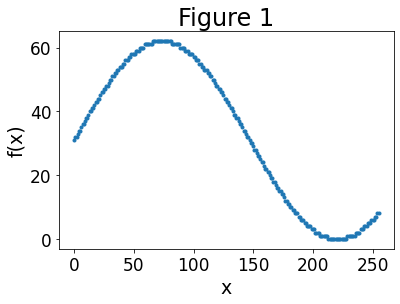

In [5]:
plt.scatter(n_inds,d_inds,marker='.')
plt.title('Figure 1')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

First let us make the state:

$$ |\psi_{\text{ini}}⟩ = \frac{1}{\sqrt{FNM}}\sum^{F-1}_{f=0}\sum^{N-1}_{n=0}\sum^{M-1}_{m=0}|f⟩|n⟩|m⟩. $$

In [6]:
# Initiating the joint states across float, time and template qubits
initial_states = np.ones((F,N,M))/np.sqrt(F*N*M)

In [7]:
def k_1(initial_states):
    '''
    This function takes the joint states and produces the template states.
    '''
    F, N, M = initial_states.shape[0], initial_states.shape[1], initial_states.shape[2]
    freqs = np.linspace(0.5, 1, M)
    times = np.arange(N)
    t_inds = np.round(((F/2)-1)*np.sin(freqs*np.vstack(times)*(2*np.pi)/N)+(F/2)-1).astype(int)
    Templates = np.zeros((F,N,M))
    for m in np.arange(M):
        for n in np.arange(N):
            Templates[t_inds[n,m],n,m]=1./np.sqrt(N*M)
    return Templates

The template states are made by applying $\hat{k}_{1}$ to $|\psi_{\text{ini}}⟩$:

$$|T⟩ = \hat{k}_{1}|\psi_{\text{ini}}⟩.$$

In [8]:
# Apply k1 to form the templates
Templates = k_1(initial_states)

In [9]:
def get_t_inds(initial_states):
    '''
    A function simply used for plotting the templates and not used in the circuit.
    It takes the initial states and produces templates represented as floats.
    '''
    F, N, M = initial_states.shape[0], initial_states.shape[1], initial_states.shape[2]
    freqs = np.linspace(0.5, 1, M)
    times = np.arange(N)
    return np.round(((F/2)-1)*np.sin(freqs*np.vstack(times)*(2*np.pi)/N)+(F/2)-1).astype(int)

We can see what the templates look like:

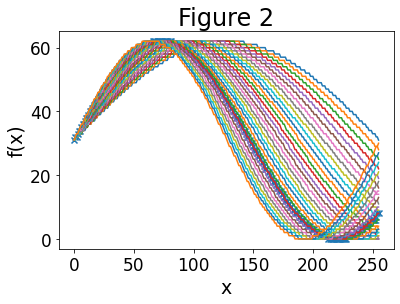

In [10]:
plt.scatter(n_inds,d_inds,marker='x',label='Data')
plt.title('Figure 2')
plt.xlabel('x')
plt.ylabel('f(x)')

t_inds = get_t_inds(initial_states)

for m in m_inds:
    plt.plot(n_inds,t_inds[:,m])
plt.show()

In [11]:
def k_2(Templates, Data):
    '''
    k_2 compares the templates to data and produces a state "w" that is in
    equal superposition across all states, but with a phase flip of "-1" infront
    of a template index that matches the data.
    Currently considers an exact match.
    '''
    F, N, M = Templates.shape[0], Templates.shape[1], Templates.shape[2]
    w = np.ones(M)/np.sqrt(M)
    for m in np.arange(M):
        if np.all(Templates[:,:,m]*np.sqrt(N*M)==Data*np.sqrt(N*F)):
            w[m]=w[m]*-1
    return w

$|w⟩$ is made by applying $\hat{k}_{2}$ to $|T⟩\otimes|D⟩$:

$$|w⟩ = \hat{k}_{2}(|T⟩\otimes|D⟩).$$

In [12]:
# Compare the templates to the data to get states w
w = k_2(Templates, Data)

Then we make the state:

$$ |\psi_{0}⟩ = \frac{1}{\sqrt{PM}}\sum^{P-1}_{p=0}\sum^{M-1}_{m=0}|p⟩|m⟩. $$

This is equivalent of the state $|s⟩$ previously made, but $P$ times.

In [13]:
# Initialising joint state psi_0 which we apply Grover's algorithm over given w
psi_0 = np.ones((M,P))/np.sqrt(M*P)

The first part of Grover's algorithm is then applied as follows:

1. Create operator $\hat{U}_{w}=\mathcal{I}-2|w⟩⟨w|$ where $w$ is the matrix position corresponding to the matching templates. This operator has the property:

$$ \hat{U}_{w} |x⟩ = -|x⟩ \text{ if } x=w, $$
$$ \hat{U}_{w} |x⟩ = |x⟩ \text{ if } x\ne w.\ \ \$$

2. Initiate superposition:

$$ |s⟩ = \frac{1}{\sqrt{M}}\sum^{M-1}_{x=0}|x⟩, $$

assuming that every template is equally likely to have the correct template without any more prior knowledge.

3. Create the Grover diffusion operator $\hat{U}_{s}=2|s⟩⟨s|-\mathcal{I}$.

4. Apply $\hat{U}_{w}$ then $\hat{U}_{s}$ to $|s⟩$ $p$ times to each state in $P$ ($p=\{0,1,...P-1\}$).

In [14]:
def U_w(w):
    '''
    Defines the matrix operation applied to psi_0 given w.
    This operator flips the phase of a state that corresponds to w.
    '''
    M = len(w)
    return np.sqrt(M)*np.multiply(np.eye(M),w)

In [15]:
def U_s(w):
    '''
    Defines the matrix operation applied to psi_0 given w.
    This is "Grovers diffusion operator". 
    '''
    M = len(w)
    s_i = np.array([np.ones(M)/np.sqrt(M)]).T
    return 2*np.outer(s_i,s_i)-np.eye(M)

In [16]:
def Grovers1(w, psi_0):
    '''
    This corresponds to the first part of Grovers algorithm.
    Here operators U_w and U_s are applied to psi_0 "p" times for each of the P states.
    '''
    M, P = psi_0.shape[0], psi_0.shape[1]
    psi_1 = np.zeros((M,P))
    for p in np.arange(P):
        psi_1[:,p] = np.dot(np.linalg.matrix_power(np.matmul(U_s(w),U_w(w)),p),psi_0[:,p])
    return psi_1

Now we apply Grover's algorithm itterably to this state such that:

$$ |\psi_{1}⟩ = \hat{C}_{G}|\psi_{0}⟩, $$

where $\hat{C}_{G}|p⟩\otimes |m⟩\rightarrow |p⟩\otimes (\hat{G})^{p}|m⟩$,

and $\hat{G}=\hat{U_{s}}\hat{U_{w}}$.

In [17]:
# Apply the first part of Grover's algorithm
psi_1 = Grovers1(w,psi_0)

We can see what this operation does to $|\psi_{0}⟩$ in the plot bellow:

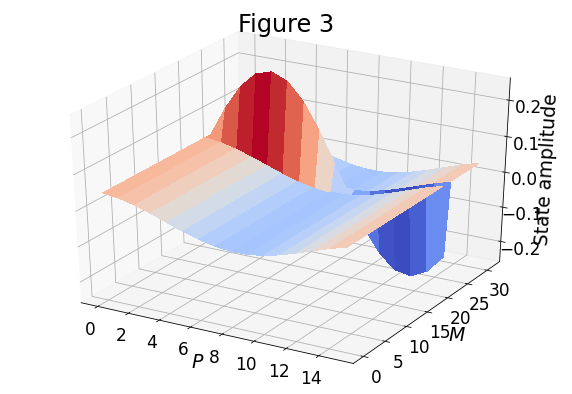

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X, Y = np.meshgrid(p_inds, m_inds)
Z=psi_1
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title('Figure 3')
ax.set_xlabel(r'$P$')
ax.set_ylabel(r'$M$')
ax.set_zlabel('State amplitude')

plt.show()

We see the amplitudes of states $\psi_{1}$ numbering $P\times M$. Where the amplitudes of the states around correct solutions are much greater than the incorrect solutions. The incorrect solutions also exhibit a sinusoidal pattern. 

It is the frequency $f$ of this sinusoid that we wish to determine, as it is related to the number of correct template matches $k$ by:

$$ k = \sin^{2}\frac{f\pi}{P}. $$

Determining phase/frequency information from amplitudes of states requires a *quantum fourier transform*.

### Quantum Fourier Transform

The *quantum fourier transform* is much the same as it's classical counterpart but is performed on amplitude/phase information stored on the states of qubits. It transfers information stored in amplitudes in quantum states into phase information. There also exists the inverse quantum fourier transform for the reverse opperation.

The quantum fourier transform acting on state $|p⟩$ gives:

$$ \mathrm{QFT}:|x⟩ \mapsto \frac{1}{\sqrt{K}}\sum^{K-1}_{k=0}e^{2\pi i\frac{kx}{K}}|k⟩. $$

The inverse quantum fourier transform is applied across the ancillary qubits the recover the phase information from the sinusoidal behaviour in the states shown in the graph above. This requires creating a $QFT^{-1}$ operator of size $P\times P$, which we will call $\hat{F}_{P}$ as done below:

In [19]:
def IQFT(P):
    '''
    Constructing the inverse fourier transform of size PxP.
    '''
    return np.round(
            np.array([[(np.exp(-2.*i*j*1j*np.pi/P)) 
                   for j in np.arange(P)] 
                    for i in np.arange(P)]),1)*1./np.sqrt(P)

In [20]:
def Grovers2(psi_1):
    '''
    The seconds part of Grovers algorithm. 
    Here we apply the inverse quantum Fourier transform to psi_2.
    '''
    M, P = psi_1.shape[0], psi_1.shape[1]
    return np.dot(IQFT(P),psi_1.T)

Applying this across the ancillary states in $|\psi_{1}⟩$:

$$ \psi_{2} = \hat{F}_{P}\psi_{1}. $$

In [21]:
# We apply the second part of Grover's algoirthm to state psi_1
psi_2 = Grovers2(psi_1)

This operation changes $|\psi_{1}⟩$ to the states in the plot bellow (note that I now show the state probability and not the amplitudes in the $z$ axis): 

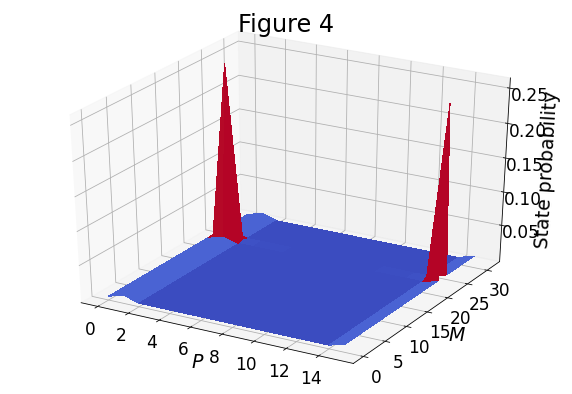

In [22]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

X, Y = np.meshgrid(p_inds, m_inds)
Z=np.absolute(psi_2).T**2
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title('Figure 4')
ax.set_xlabel(r'$P$')
ax.set_ylabel(r'$M$')
ax.set_zlabel('State probability')

plt.show()

The probabilities $|\psi_{2}|^{2}$ are seen over ancillary and template states. There are two peaks, corresponing to $f$ and $P-f$. Measuring the ancillary state will likely acquire one or the other. These peaks also correspond to the positions of matching templates, and so measuring the template qubits likely recovers a correct position of a template.

From knowing $f$ or $P-f$ we can work out the number of matched templates $k$ with the relation:

$$ k = \sin^{2}\frac{f\pi}{P}. $$

Doing this gives the number of matching templates for this example as:

In [23]:
# Measure each of the qubits corresponding to template states M and period states P
measurement = np.unravel_index(np.argmax(np.absolute(psi_2)**2), psi_2.shape)

# The resulting state measured from the P qubits tells us about the number of matching templates
P_measured = measurement[0]

# The state measured from the M qubits gives one matching template
M_measured = measurement[1]

In [24]:
# The result from measuring P corresponds to the frequency of the sinesoid shown in Figure 3
N_templates = int(M*np.sin(P_measured*np.pi/P)**2)

# The measured state from M corresponds to the index of the predicted freqnecy of the signal sine wave
f_pred = np.linspace(0.5,1.,M)[M_measured]

In [25]:
print('Number of predicted matches:', N_templates)
print('Predicted frequency:', f_pred)
print('True frequency:', f_data)

Number of predicted matches: 1
Predicted frequency: 0.8709677419354839
True frequency: 0.8709677419354839
